<a href="https://colab.research.google.com/github/vadim-privalov/-/blob/main/%D0%A1%D1%80%D0%B0%D0%B2%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Финальный проект. Решение задачи бинарной классификаци, сравнение классических линейных моделей и простейшей нейросети**

Вашему вниманию представлена задача по классификации совершенной транзакции , совершил ли ее сам клиент или его данными воспользовались мошенники.
В этом наборе данных представлены транзакции, которые произошли за два дня, из которых у нас 492 мошенничества из 284 807 транзакций. Набор данных сильно несбалансирован, на положительный класс (мошенничество) приходится 0,172% всех транзакций.

К сожалению, из-за проблем с конфиденциальностью данные зашифрованны. Характеристики V1, V2,… V28 - это основные компоненты нашего датасета, единственными функциями, которые не были преобразованы, являются «Время» и «Количество». Функция «Время» содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. Функция «Сумма» - это сумма транзакции. Функция «Класс» - это переменная ответа, которая принимает значение 1 в случае мошенничества и 0 в противном случае.

Т.к. наш датасет большого размера (> 25Мб), то копируем его на Гугл диск, подключаем "Драйвер" связи ноутбука и диска и указываем путь к нашим данным

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!ls '/content/drive/MyDrive/creditcard.csv'

/content/drive/MyDrive/creditcard.csv


Импортируем необходимые нам для работы библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import warnings
pd.options.display.max_rows = 10
from imblearn.under_sampling import TomekLinks
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from random import sample
from sklearn.model_selection import cross_val_score, train_test_split
from  sklearn.feature_extraction.text import CountVectorizer
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Загружаем наш датафрейм и открываем его

In [ ]:
df = pd.read_csv(filepath_or_buffer = "/content/drive/MyDrive/creditcard.csv",
                           sep = ',')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Имеем 31 столбец и 284 807 строк. Датафрейм большого размера и имеет смысл удалить из него данные, которые ни какого влияния на ожидаемый результат не окажут, а только в холостую будут расходовать вычислительные способности компьютера.
Т.к. мы однозначно не можем удалить данные V.....(мы просто не знаем что они подразумевают и какую роль играют), но вот данные "Time" на совершенно не нужны, поэтому просто удалим весь столбец

In [ ]:
del df['Time']
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Выводим статистику по нашим столбцам, для того, что бы попытаться оценить наши данные в первом приближении

In [ ]:
df.describe() 

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Видим, что значения по столбцу "Траты" имеют огромный разброс по данным

Вычисляем количество значений, отличных от NaN, по каждому столбцу, что бы исключить ошибки в дальнейшем

In [ ]:
df.count(axis=0) 

V1        284807
V2        284807
V3        284807
V4        284807
V5        284807
           ...  
V26       284807
V27       284807
V28       284807
Amount    284807
Class     284807
Length: 30, dtype: int64

У нас не NaТ, т.к. число значений отличных от NaN совпадает с общим числом строк

Посмотрим на типы данных наших столбцов:

In [ ]:
df.dtypes

V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
           ...   
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
Length: 30, dtype: object

Все данные нашего датафрейма имеют "цифровой" вид, т.е. нет категориальных данных и отпадает необходимость проводить кодировку.

Перемешиваем наш датафрейм

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.410619,-1.009365,0.184630,-1.379168,-1.422450,-1.063709,-0.664360,-0.174446,-2.273997,1.618986,1.365454,-0.507570,-0.566037,0.299992,-0.255918,-0.389869,0.496327,-0.033225,0.241404,-0.316915,-0.488213,-1.240060,0.201232,0.438873,0.136254,-0.559070,-0.006472,0.015558,49.90,0
1,1.202023,0.109317,0.217145,0.193697,-0.306459,-1.000975,0.124776,-0.306617,1.322301,-0.593052,1.224810,-2.133244,1.565823,1.874033,0.388089,-0.411406,0.946169,-0.910133,-0.532673,-0.107395,-0.169405,-0.239903,0.027137,0.414827,0.275356,1.009209,-0.118300,-0.006739,32.00,0
2,2.016247,0.166647,-1.745843,0.524195,0.231544,-1.386145,0.306779,-0.389984,0.541653,-0.498994,-0.304668,0.238711,0.341921,-0.789210,0.916111,0.151338,0.408880,0.396701,-0.486326,-0.149729,0.212387,0.769238,-0.043467,-0.137379,0.251802,-0.097144,-0.000751,-0.028304,22.80,0
3,2.071229,-0.164599,-1.158184,0.396703,-0.207664,-1.165591,0.078853,-0.239411,0.781389,0.117999,-1.131849,-0.417111,-1.427549,0.568606,0.217312,0.009030,-0.254980,-0.635293,0.211914,-0.316478,-0.316302,-0.850633,0.340030,-0.151909,-0.330108,0.210149,-0.080881,-0.064660,1.98,0
4,-0.797718,-0.570103,0.037638,-2.168010,1.194625,-1.206352,0.657955,-0.182741,-1.643850,-0.009793,0.325004,-0.260299,-0.299902,0.154574,-2.098648,0.640170,0.003010,-1.214901,0.586310,0.247067,0.409771,0.867900,-0.225873,-0.351682,0.455894,-0.102062,0.016626,0.116949,56.96,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-0.724152,1.021383,1.132639,-1.544895,0.247339,-0.676981,0.837985,-0.266815,0.092266,0.252803,1.176852,0.813743,0.557649,-0.267903,-0.301848,0.622791,-1.167308,0.019287,-0.324517,0.242852,-0.077948,-0.045516,-0.151349,0.048324,-0.176779,0.717371,-0.149800,-0.091023,0.79,0
284803,-1.518731,1.024115,1.763515,-0.989589,-0.762285,-0.363313,0.164776,0.198028,0.965062,0.475019,0.916405,0.489324,-0.886602,-0.505790,-1.080060,0.209905,-0.485581,0.213983,-0.217645,0.228652,0.049149,0.628476,-0.183944,0.598371,-0.191161,0.892681,-0.216486,-0.219761,12.99,0
284804,-1.258704,-0.032560,3.760179,4.880899,0.696797,3.786621,-1.402996,0.883948,0.873015,0.887910,1.208067,-1.860606,1.928294,0.134696,-1.597374,-1.187173,1.855962,-0.208504,0.656236,0.062953,0.004550,1.040622,-0.433750,-1.326326,-0.182111,0.681577,0.043642,-0.185071,57.05,0
284805,1.187322,0.010091,0.075855,1.342862,1.595523,4.294689,-1.306149,1.162367,-0.217213,0.691915,-0.407903,-0.266782,0.260515,-0.092139,1.279121,1.628971,-1.437861,0.900218,-1.048755,-0.001973,0.177577,0.373311,-0.058398,1.004974,0.413102,0.126034,0.049653,0.034768,1.18,0


Выделим целевую переменную в отдельный формат и удалим ее из обучающей выборки.

In [ ]:
y = np.array(df['Class'])
X = df.drop(['Class'], axis = 1)
X

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,1.410619,-1.009365,0.184630,-1.379168,-1.422450,-1.063709,-0.664360,-0.174446,-2.273997,1.618986,1.365454,-0.507570,-0.566037,0.299992,-0.255918,-0.389869,0.496327,-0.033225,0.241404,-0.316915,-0.488213,-1.240060,0.201232,0.438873,0.136254,-0.559070,-0.006472,0.015558,49.90
1,1.202023,0.109317,0.217145,0.193697,-0.306459,-1.000975,0.124776,-0.306617,1.322301,-0.593052,1.224810,-2.133244,1.565823,1.874033,0.388089,-0.411406,0.946169,-0.910133,-0.532673,-0.107395,-0.169405,-0.239903,0.027137,0.414827,0.275356,1.009209,-0.118300,-0.006739,32.00
2,2.016247,0.166647,-1.745843,0.524195,0.231544,-1.386145,0.306779,-0.389984,0.541653,-0.498994,-0.304668,0.238711,0.341921,-0.789210,0.916111,0.151338,0.408880,0.396701,-0.486326,-0.149729,0.212387,0.769238,-0.043467,-0.137379,0.251802,-0.097144,-0.000751,-0.028304,22.80
3,2.071229,-0.164599,-1.158184,0.396703,-0.207664,-1.165591,0.078853,-0.239411,0.781389,0.117999,-1.131849,-0.417111,-1.427549,0.568606,0.217312,0.009030,-0.254980,-0.635293,0.211914,-0.316478,-0.316302,-0.850633,0.340030,-0.151909,-0.330108,0.210149,-0.080881,-0.064660,1.98
4,-0.797718,-0.570103,0.037638,-2.168010,1.194625,-1.206352,0.657955,-0.182741,-1.643850,-0.009793,0.325004,-0.260299,-0.299902,0.154574,-2.098648,0.640170,0.003010,-1.214901,0.586310,0.247067,0.409771,0.867900,-0.225873,-0.351682,0.455894,-0.102062,0.016626,0.116949,56.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-0.724152,1.021383,1.132639,-1.544895,0.247339,-0.676981,0.837985,-0.266815,0.092266,0.252803,1.176852,0.813743,0.557649,-0.267903,-0.301848,0.622791,-1.167308,0.019287,-0.324517,0.242852,-0.077948,-0.045516,-0.151349,0.048324,-0.176779,0.717371,-0.149800,-0.091023,0.79
284803,-1.518731,1.024115,1.763515,-0.989589,-0.762285,-0.363313,0.164776,0.198028,0.965062,0.475019,0.916405,0.489324,-0.886602,-0.505790,-1.080060,0.209905,-0.485581,0.213983,-0.217645,0.228652,0.049149,0.628476,-0.183944,0.598371,-0.191161,0.892681,-0.216486,-0.219761,12.99
284804,-1.258704,-0.032560,3.760179,4.880899,0.696797,3.786621,-1.402996,0.883948,0.873015,0.887910,1.208067,-1.860606,1.928294,0.134696,-1.597374,-1.187173,1.855962,-0.208504,0.656236,0.062953,0.004550,1.040622,-0.433750,-1.326326,-0.182111,0.681577,0.043642,-0.185071,57.05
284805,1.187322,0.010091,0.075855,1.342862,1.595523,4.294689,-1.306149,1.162367,-0.217213,0.691915,-0.407903,-0.266782,0.260515,-0.092139,1.279121,1.628971,-1.437861,0.900218,-1.048755,-0.001973,0.177577,0.373311,-0.058398,1.004974,0.413102,0.126034,0.049653,0.034768,1.18


Построим гистограммы и оценим распределение величин по признакам в наших данных

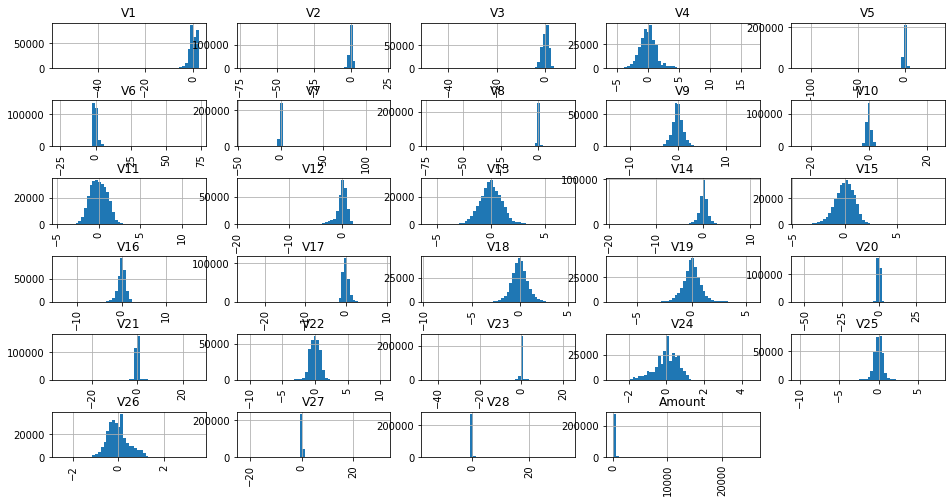

In [ ]:
fig = plt.figure(figsize=(16,8))
cols = 5

rows = np.ceil(float(X.shape[1]) / cols)
for i, column in enumerate(X.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    X[column].hist(axes=ax, bins=50)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

Наши данные сильно не сбалансированны

Построим матрицу корреляций, выбросим данные с единичной линейной зависимостью - они просто повысят вычислительную сложность модели.

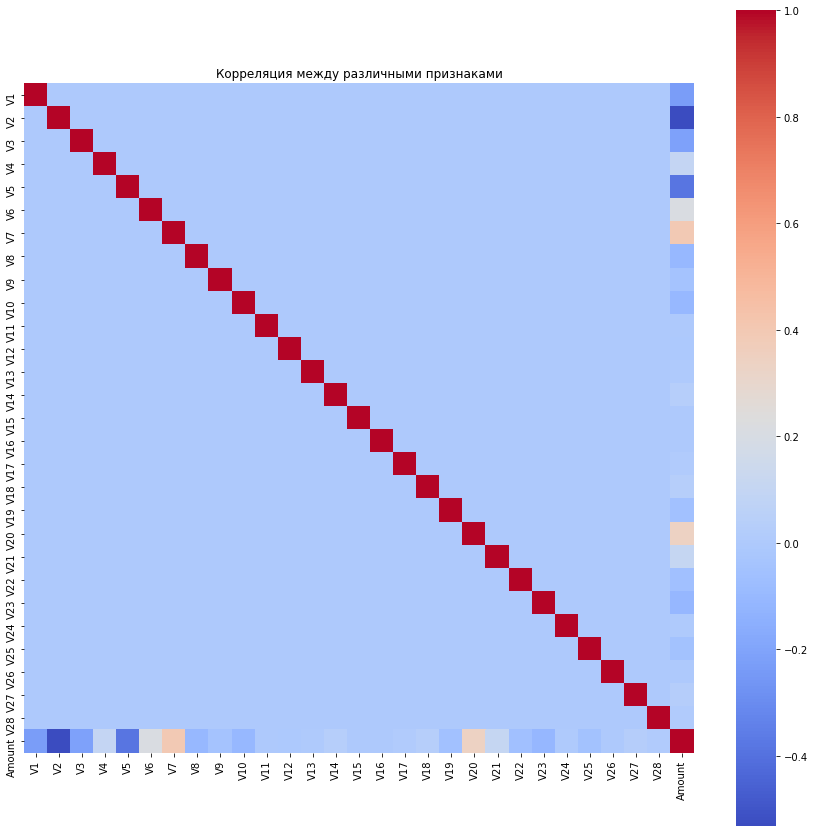

In [ ]:
correlation = X.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation, square=True, cmap= 'coolwarm')
plt.title('Корреляция между различными признаками')
plt.show()

"Тепловая карта" позволяет сделать вывод об отсутствии "единичных" зависимостей и следовательно нет необходимости сокращаь наши данные.

Создадим обучающую выборку Х, переведем получанные цифровые данные в np.array

In [ ]:
X = np.array(X[X.columns])
X

array([[ 1.41061910e+00, -1.00936458e+00,  1.84630292e-01, ...,
        -6.47194828e-03,  1.55581850e-02,  4.99000000e+01],
       [ 1.20202338e+00,  1.09317481e-01,  2.17145422e-01, ...,
        -1.18300162e-01, -6.73889371e-03,  3.20000000e+01],
       [ 2.01624678e+00,  1.66646799e-01, -1.74584333e+00, ...,
        -7.50729768e-04, -2.83043621e-02,  2.28000000e+01],
       ...,
       [-1.25870366e+00, -3.25596694e-02,  3.76017896e+00, ...,
         4.36416415e-02, -1.85070879e-01,  5.70500000e+01],
       [ 1.18732232e+00,  1.00908277e-02,  7.58552234e-02, ...,
         4.96533263e-02,  3.47682461e-02,  1.18000000e+00],
       [ 1.22284621e+00,  3.80376668e-01,  4.82128750e-01, ...,
         2.69282164e-02,  2.84882254e-02,  9.99000000e+00]])

Т.к. изначально мы определили, что наши данные сильно разбросаны, нормализуем их

In [ ]:
from sklearn.preprocessing import scale
X_scaled = scale(np.array(X, dtype='float'), with_std=True, with_mean=True)
X_scaled

array([[ 7.20184099e-01, -6.11252413e-01,  1.21767523e-01, ...,
        -1.60342879e-02,  4.71342052e-02, -1.53724892e-01],
       [ 6.13686664e-01,  6.62006325e-02,  1.43211929e-01, ...,
        -2.93089311e-01, -2.04157747e-02, -2.25290635e-01],
       [ 1.02938410e+00,  1.00918201e-01, -1.15142004e+00, ...,
        -1.85993718e-03, -8.57493090e-02, -2.62073028e-01],
       ...,
       [-6.42624477e-01, -1.97175300e-02,  2.47991634e+00, ...,
         1.08122410e-01, -5.60680363e-01, -1.25138576e-01],
       [ 6.06181114e-01,  6.11081754e-03,  5.00280997e-02, ...,
         1.23016393e-01,  1.05331930e-01, -3.48511651e-01],
       [ 6.24317646e-01,  2.30349034e-01,  3.17973952e-01, ...,
         6.67148062e-02,  8.63063309e-02, -3.13288512e-01]])

Затем находим индексы в зависимости от метки класса и выбрасываем лишние.

In [ ]:
# np.argwhere вернет индексы тех элементов массива y (целевой переменной), где значение 0
not_churn_ids = np.argwhere(y == 0).flatten()
print('Всего не ушедших', len(not_churn_ids))
not_churn_ids

Всего не ушедших 284315


array([     0,      1,      2, ..., 284804, 284805, 284806])

Перемешаем массив с выбранным random state (чтоб в дальнейшем у нас совпадали выборки) выберем в нем "лишние" id тех, кто остались (кто портит нам прогноз алгоритма). Кол-во "лишних" = кол-во оставшихся - кол-во ушедшых.

In [ ]:
from sklearn.utils import shuffle

not_churn_ids = shuffle(not_churn_ids, random_state = 42)
not_churn_ids = not_churn_ids[len(np.argwhere(y == 1).flatten()):]
print(len(not_churn_ids))
not_churn_ids

283823


array([140114,  28819,  73320, ..., 132159, 147117, 122167])

Проверим, сбалансированны ли классы, (оставшиеся) - ("лишние") = (ушедшие)

In [ ]:
len(np.argwhere(y == 0).flatten()) - len(not_churn_ids) == len(np.argwhere(y == 1).flatten())

True

Удаляем "лишние" id из X и y

In [ ]:
# np.delete принимает массив, индексы, которые выбросить и по какой оси выкидывать
X = np.delete(X_scaled, not_churn_ids, 0)
y = np.delete(y, not_churn_ids, 0)

Выводим размеры наших выборок

In [ ]:
X.shape, y.shape

((984, 29), (984,))

Разбиваем наши выборки на обучающие и тестовые в соотношении 100/20 (они нам понадобятся в дальнейшем)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Сохраним дополнительно массив X_ml, он понадобится нам в дальнейшем при работе с моделью MLPC

In [ ]:
X_ml = X

Инициализируем и попробуем построить три классические модели для решения нашей задачи (логистическая регрессия, случайный лес и метод ближайших сосоедей), затем отобразим построенные гиперплоскости полученные в ходе обучения наших моделей

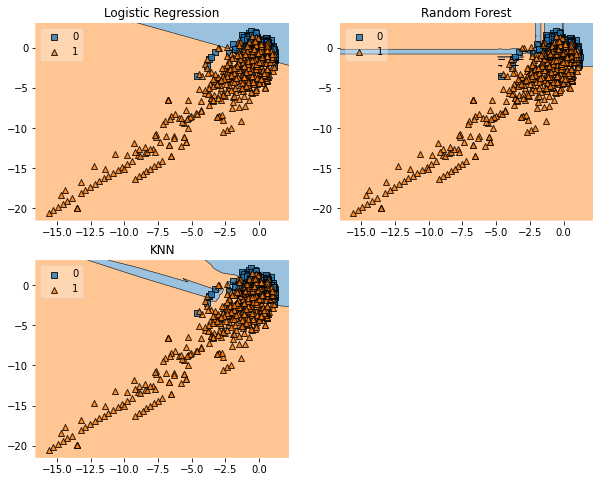

In [ ]:
import matplotlib.gridspec as gridspec
import itertools
from mlxtend.plotting import plot_decision_regions

# Initializing Classifiers
clf1 = LogisticRegression(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
clf3 = KNeighborsClassifier(n_neighbors = 3)

X = X[:,[0, 2]]

# Plotting Decision Regions
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))

for clf, lab, grd in zip([clf1, clf2, clf3],
                         ['Logistic Regression', 'Random Forest', 'KNN'],
                         itertools.product([0, 1], repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)
plt.show()

Видим, что наши гиперплоскост построены не совсем корректно, поэтому попытаемся оптимизировать наши алгоритмы с помощью подбора классификаторов (мультикласс, OneVsOne - один против одного и OneVsRest - один против двух (в нашем случае)) и выведем значения предсказания наших моделей.

Выбрав модель Random Forest Multiclass получаем метрики 

In [ ]:
from sklearn.metrics import recall_score
from sklearn import metrics
rf = RandomForestClassifier(max_depth=3, n_estimators=100, random_state = 2)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(metrics.classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.91      1.00      0.95        96
           1       1.00      0.90      0.95       101

    accuracy                           0.95       197
   macro avg       0.95      0.95      0.95       197
weighted avg       0.95      0.95      0.95       197



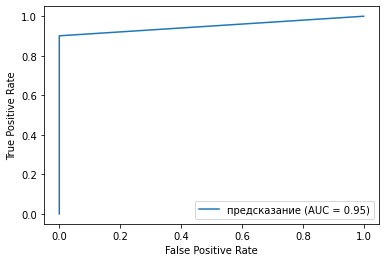

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='предсказание')
display.plot()  
plt.show()   


Для решения нашей задачи попробуем построить нейронню сеть MLPClassifier (Многослойный классификатор персептрона), которая оптимизирует функцию логарифмических потерь с помощью стохастического градиентного спуска. Задаем размер нейронного слоя - 200, адаптивную скороть обучения и максимальное количество итераций - 10000. Обучаем нашу модель и получаем значение предсказаний.

In [ ]:
from sklearn.metrics import recall_score
from sklearn.neural_network import MLPClassifier

In [ ]:
MLPC = MLPClassifier(hidden_layer_sizes=(200,), learning_rate = 'adaptive', max_iter=10000)
MLPC.fit(X_train, y_train)
y_pred = MLPC.predict(X_test)
# Получаем значения recall
recall_acc = recall_score (y_test,y_pred)
print('Точность',recall_acc)

Точность 0.9405940594059405


Посмотрим на метрики качества нашей нейросети через classification report

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        96
           1       1.00      0.94      0.97       101

    accuracy                           0.97       197
   macro avg       0.97      0.97      0.97       197
weighted avg       0.97      0.97      0.97       197



Соотношение f1 имеет довольно хорошие значения

Посмотрим на полученную гиперплоскость

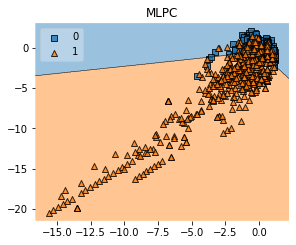

In [ ]:
clf1 = MLPClassifier(hidden_layer_sizes=(200,), learning_rate = 'adaptive', max_iter=10000)


X_ml = X_ml[:,[0, 2]]

# Plotting Decision Regions
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(10, 8))

for clf, lab, grd in zip([clf1],
                         ['MLPC'],
                         itertools.product([0, 1], repeat=2)):
    clf.fit(X_ml, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)
plt.show()

Построим ROC кривую

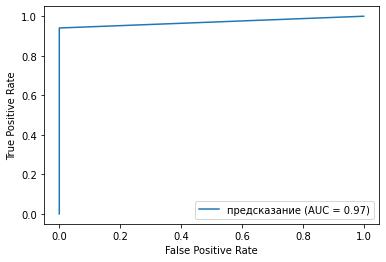

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='предсказание')
display.plot()  
plt.show() 